# **Mount the google drive to google colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Required Module**



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from keras.models import Sequential
from IPython.display import display
from PIL import Image
from tensorflow.keras.losses import categorical_crossentropy
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
import numpy as np
import cv2
from keras.optimizers import SGD
from keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# **Read the data from csv into dataframe**

1.   Remove the age and gender column from the dataset 




In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/age_gender.csv")
df.drop(columns= ['img_name','age','gender'], axis=1, inplace= True)
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [ ]:
X = np.array(df['pixels'].tolist())
y = df['ethnicity']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)


# **# Visualize the Ethnicity distribution in the data**

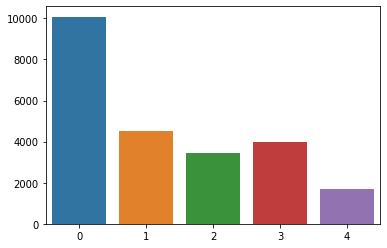

In [ ]:
import seaborn as sns
sns.barplot(y=list(df['ethnicity'].value_counts().values),x= list(df['ethnicity'].value_counts().index))



Distric=bution of data in the sample

Class=1, n=3624 (19.110%)
Class=0, n=8056 (42.480%)
Class=2, n=2723 (14.359%)
Class=3, n=3185 (16.795%)
Class=4, n=1376 (7.256%)


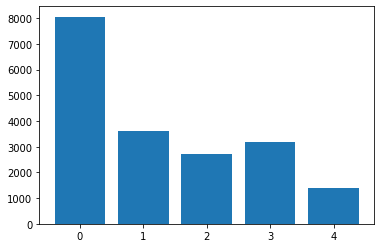

In [ ]:
from pandas import read_csv
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

y_en = LabelEncoder().fit_transform(y_train)
# summarize distribution
counter = Counter(y_en)
for k,v in counter.items():
	per = v / len(y_en) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

should we sampe before split or after split?

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Class=1, n=8056 (20.000%)
Class=0, n=8056 (20.000%)
Class=2, n=8056 (20.000%)
Class=3, n=8056 (20.000%)
Class=4, n=8056 (20.000%)


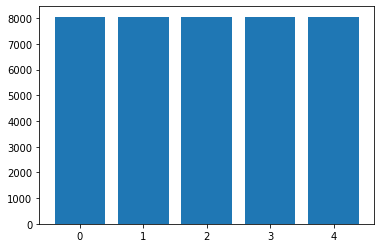

In [ ]:
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

oversample = SMOTE()
X_, y_ = oversample.fit_resample(X_train, y_train)
# summarize distribution
counter = Counter(y_)
for k,v in counter.items():
	per = v / len(y_) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
X_ = X_.reshape(X_.shape[0],48,48,1)
print(y_.shape)

Y_ =  to_categorical(y_)


(40280,)


# ***Model  with batch normalization with no balancing of the data ***

In [ ]:
#model with vgg16
#from keras.applications.resnet50 import ResNet50
from keras import  models
from keras.layers import Concatenate
from keras.applications.vgg16 import VGG16

#converting input shape of 48,48,1, to three channel as required by pre-trained the vgg16 model
img_input = Input(shape=(48,48,1))
img_conc = Concatenate()([img_input, img_input, img_input])  
vgg_cov = VGG16(weights='imagenet',include_top=False,input_tensor=img_conc)
last = vgg_cov.output
x=Flatten ()(last)
x1 = Dropout(0.3)(x)
x2 = Dense(1024,activation='relu')(x1)
x3 = Dense(512,activation='relu')(x2)
my_preds = Dense(5,activation = 'softmax')(x3)
my_model = Model(vgg_cov.input,my_preds)
my_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 48, 48, 3)    0           input_3[0][0]                    
                                                                 input_3[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 48, 48, 64)   1792        concatenate_2[0][0]              
____________________________________________________________________________________________

In [ ]:
#freeze the layer from restnet 
#for layers in my_model.layers[:20]:
   #layers.trainable = False
#for layer in my_model.layers:
  #  print(layer, layer.trainable)

In [ ]:
from keras import optimizers
#opt = optimizers.SGD(lr=0.0001,decay=0.000001, momentum=0.9)
opt =Adam(lr=0.0001,decay=0.000001)
my_model.compile(optimizer=opt,
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
#https://medium.com/clique-org/how-to-create-a-face-recognition-model-using-facenet-keras-fd65c0b092f1

Apply criteria on training when to stop( when test accuracy of 80 percent is reached)

In [ ]:
history4 = my_model.fit(X_,Y_ ,epochs=554, validation_split=0.2,validation_data = (X_test,y_test), batch_size =64)


Epoch 1/554
504/504 [==============================] - 36s 39ms/step - loss: 1.4404 - accuracy: 0.4650 - val_loss: 2.0725 - val_accuracy: 0.1339
Epoch 2/554
504/504 [==============================] - 18s 37ms/step - loss: 0.6192 - accuracy: 0.7997 - val_loss: 1.8455 - val_accuracy: 0.1392
Epoch 3/554
504/504 [==============================] - 18s 37ms/step - loss: 0.4690 - accuracy: 0.8502 - val_loss: 2.2660 - val_accuracy: 0.1631
Epoch 4/554
504/504 [==============================] - 18s 37ms/step - loss: 0.3568 - accuracy: 0.8840 - val_loss: 1.6651 - val_accuracy: 0.2073
Epoch 5/554
504/504 [==============================] - 18s 37ms/step - loss: 0.2825 - accuracy: 0.9071 - val_loss: 1.5916 - val_accuracy: 0.2649
Epoch 6/554
504/504 [==============================] - 19s 37ms/step - loss: 0.2270 - accuracy: 0.9213 - val_loss: 1.2436 - val_accuracy: 0.3690
Epoch 7/554
504/504 [==============================] - 18s 37ms/step - loss: 0.1741 - accuracy: 0.9406 - val_loss: 1.2645 - val_ac

In [ ]:
##X_test.reshape(X_test.shape[0], 48,48,1)
y_test_ = to_categorical(y_test)
print(y_test_ .shape)

x_test = X_test.reshape(X_test.shape[0], 48,48,1)

print(x_test .shape)

(4741, 5)
(4741, 48, 48, 1)


FaceNet trained on VGGFace2 dataset

The alignment module uses dlib to detect a face and create landmarks; the landmarks are then adjusted to
create uniformity in the faces that are passed in. Relatively however the dataset that was used (UTKFace)
already had most of the faces cropped and adjusted to have the facial features centred to the picture. However
in the case of using a raw image or during a live session, the images captured needed to be cropped and
aligned for accurate predictions.https://coursys.sfu.ca/2020sp-cmpt-726-x1/pages/ARG_report/view

# **visualize** the train test accuracy and loss plot to check for overfitting

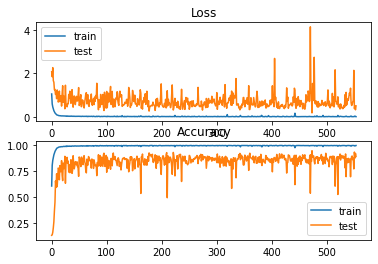

In [ ]:
# evaluate the model


train_acc = my_model.evaluate(X_,Y_, verbose=0)
test_acc = my_model.evaluate(x_test,y_test_, verbose=0)

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history4.history['loss'], label='train')
plt.plot(history4.history['val_loss'], label='test')
plt.legend()




# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history4.history['accuracy'], label='train')
plt.plot(history4.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:


#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [ ]:
preds_t=my_model.predict(x_test)  
test_acc=my_model.evaluate(x_test,y_test_)  
print("Testing loss and accuracy :",  test_acc)

149/149 [==============================] - 1s 8ms/step - loss: 1.9723 - accuracy: 0.8165
Testing loss and accuracy : [1.9722704887390137, 0.8164944052696228]


In [ ]:
#classification report
class_names=[ 'White American','African American' ,'Asian' ,'Indian','Others'] 
from sklearn import metrics
classification_report = metrics.classification_report( test_label, predicted_label,target_names =class_names )
print(classification_report)

                  precision    recall  f1-score   support

  White American       0.83      0.89      0.86      2022
African American       0.82      0.88      0.85       902
           Asian       0.93      0.85      0.89       711
          Indian       0.78      0.73      0.75       790
          Others       0.45      0.30      0.36       316

        accuracy                           0.82      4741
       macro avg       0.76      0.73      0.74      4741
    weighted avg       0.81      0.82      0.81      4741



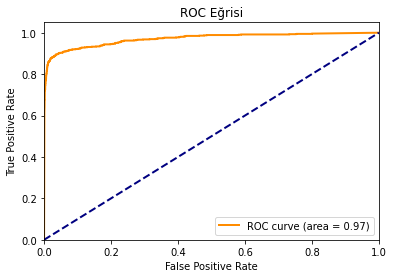

In [ ]:
#ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
y_score= my_model.predict(x_test)
y_test = label_binarize(y_test_, classes=[0,1,2,3,4])
# Learn to predict each class against the other

n_classes = 5 # number of class
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], threshold  = roc_curve(y_test[:,i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2 # line_width
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2]) # Drawing Curve according to 2. class 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

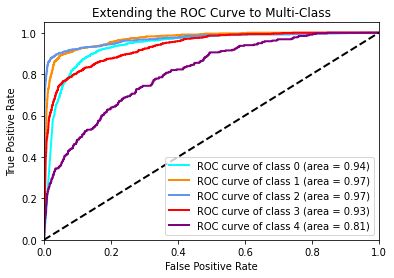

In [ ]:
from itertools import cycle 
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
class_names=[ 'White American','African American' ,'Asian' ,'Indian','Others'] 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
#plt.plot(fpr["micro"], tpr["micro"],
         #label='micro-average ROC curve (area = {0:0.2f})'
               #''.format(roc_auc["micro"]),
         #color='deeppink', linestyle=':', linewidth=4)

#plt.plot(fpr["macro"], tpr["macro"],
         #label='macro-average ROC curve (area = {0:0.2f})'
              # ''.format(roc_auc["macro"]),
         #color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extending the ROC Curve to Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
my_model.save('my_model.hdf5')

from keras.models import load_model
race_model1 = load_model("/content/my_model.hdf5")